# Hackathon : Reinforcement Learning for Drone Navigation

- Team name:
- Team members names:

## 0. Prerequisites

In [7]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [3]:
%load_ext autoreload
%autoreload 2

import torch
from rqmix import QMIXAgent
import simulate

# Drone Swarm Labyrinth RL: A Week of Exploration

## 1. Training

Considering the problem caracteristic in particular the fact that this is a multi agent envrionement with discrete action space. We choose to explore Qmix strategies.

**QMIX Strategy Overview**

QMIX is a value-based multi-agent reinforcement learning algorithm designed to handle the challenges of decentralized execution with centralized training. It works by learning individual Q-values for each agent while using a mixing network to combine these values into a joint team Q-value. The beauty of QMIX is its monotonicity constraint - it ensures that if an individual agent's action improves its local Q-value, it also improves the team's Q-value, allowing for decentralized execution.


**Our Reinforcement Learning Journey**
1. Adding Memory with RNN Layers
When our initial QMIX implementation failed to converge, we enhanced the agent's architecture with a recurrent neural network (RNN) layer : 1 then 2. The idea was to provide our agents with memory of previous states, which should theoretically help them make better decisions in partially observable environments. Despite this promising approach, our agents still wandered aimlessly, unable to find a reliable path to the goal.

2. State Normalization
In an attempt to simplify the learning problem, we modified the input state representation by rotating all states to a standardized orientation. This meant that from the agent's perspective, they always started in the top-left corner (0,0), with the goal consistently placed at the opposite end of the grid. We hoped this would make the learning task more consistent, but alas, our drones continued to stroll around rather than finding their path.

3. Success Buffer Implementation
Next came our "success buffer" approach - a specialized replay memory that prioritized storing and resampling successful episodes. The idea was to help our agents learn from their rare victories. This approach finally showed some promise! Our agents started converging... but only in empty environments without any walls. The moment we introduced complexity, they were (mostly) lost again.

4. Spatial Convolution Mixer
Growing more ambitious, we redesigned our architecture to use a central state representation with all spatial information encoded as a grid. We added convolutional layers to our mixer network, hoping to capture spatial relationships better. Unfortunately, this sophisticated approach suffered from recurring gradient explosions that we couldn't successfully mitigate. Our beautiful neural network was learning too enthusiastically for its own good!

5. Behavior Cloning from A* Agent
In what felt like a stroke of genius, we created an A* agent that could navigate the maze perfectly (our proudest achievement of the week!) and tried to teach our RL agents to mimic this behavior through behavior cloning. The A* CLONED agent performed brilliantly, but unfortunately, the transfer learning to our QMIX was less than stellar.

6. MAPPO Approach
In desperation, we pivoted to MAPPO (Multi-Agent Proximal Policy Optimization), an actor-critic method that extends PPO to multi-agent settings. Unlike value-based methods like QMIX, MAPPO directly optimizes a policy using trust region methods, which can be more stable for complex environments. It maintains a centralized critic for value estimation while allowing decentralized actors for execution. Despite MAPPO's theoretical advantages for cooperation tasks, our implementation still failed to converge, leaving our drones as confused as ever.


Throughout this journey, our drone swarm seemed determined to prove that navigating mazes is indeed a challenging problem, even for state-of-the-art reinforcement learning algorithms!


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"{device=}")

agent = QMIXAgent(
    num_agents=4,
    device=device,
    hidden_size=128,
    num_rnn_layers=1,
    qmix_embedding_size=128,
    qmix_hypernet_size=128,
    buffer_size=1000,
    batch_sequence_length=15,
    batch_size=64,
    lr=1e-4,
    gamma=0.99,
    epsilon=1.0,
    epsilon_end=0.01,
    epsilon_decay=0.9995,
    target_update_freq=1,
    tau=5e-3,
    gradient_clipping_value=10.0,
)

trained_agent, all_rewards = simulate.train('train_config/config_wall_0.json', agent)

device=device(type='cuda')
Using QMIX agent with mixer network
DRQNNetwork(
  (feature_layer): Sequential(
    (0): Linear(in_features=42, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (gru): GRU(128, 128, batch_first=True)
  (output_layer): Linear(in_features=128, out_features=7, bias=True)
)
MixingNetwork(
  (hyper_w1): Sequential(
    (0): Linear(in_features=949, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=512, bias=True)
  )
  (hyper_w2): Sequential(
    (0): Linear(in_features=949, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (hyper_b1): Linear(in_features=949, out_features=128, bias=True)
  (hyper_b2): Sequential(
    (0): Linear(in_features=949, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

Episode 1, Step 200, 

In [6]:
trained_agent, all_rewards = simulate.train('train_config/config_wall_1.json', trained_agent)


Episode 1, Step 100, Rolling reward: -1682.40, Reward: -1682.40, Evacuated: 0, Deactivated: 2
Episode 2, Step 100, Rolling reward: -1856.76, Reward: -2031.12, Evacuated: 0, Deactivated: 3
Episode 3, Step 100, Rolling reward: -1788.36, Reward: -1651.55, Evacuated: 0, Deactivated: 2
Episode 4, Step 100, Rolling reward: -2031.42, Reward: -2760.62, Evacuated: 0, Deactivated: 3
Episode 5, Step 100, Rolling reward: -1689.86, Reward: -323.60, Evacuated: 0, Deactivated: 1
Episode 6, Step 100, Rolling reward: -1760.08, Reward: -2111.21, Evacuated: 0, Deactivated: 3
Episode 7, Step 11, Rolling reward: -1541.51, Reward: -230.08, Evacuated: 0, Deactivated: 4
Episode 8, Step 100, Rolling reward: -1571.35, Reward: -1780.18, Evacuated: 1, Deactivated: 2
Episode 9, Step 90, Rolling reward: -1437.15, Reward: -363.57, Evacuated: 1, Deactivated: 3
Episode 10, Step 100, Rolling reward: -1582.51, Reward: -2890.75, Evacuated: 0, Deactivated: 3
Episode 11, Step 100, Rolling reward: -1594.41, Reward: -1801.4

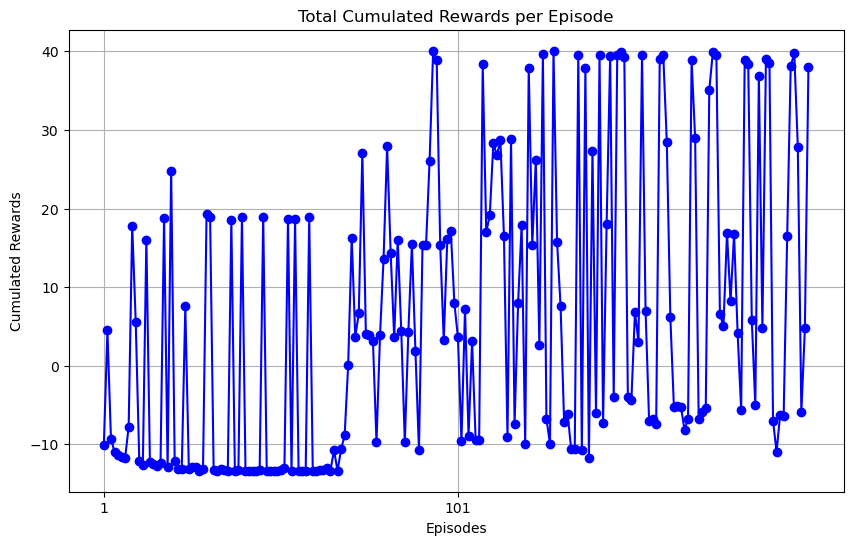

In [12]:
# Plot the cumulated rewards per episode
simulate.plot_cumulated_rewards(all_rewards)

## 2. Evaluation

In [ ]:
eval_config_paths = [f"./eval_configs/config_{i}.json" for i in range(1, 11)]

In [ ]:
all_results = simulate.evaluate(eval_config_paths, trained_agent)

In [ ]:
display(all_results)

In [ ]:
# Calculate averages for each configuration
averages = all_results.groupby('config_path').mean().reset_index().drop(columns=['episode'])
averages = averages.rename(columns={
    'steps': 'avg_steps',
    'reward': 'avg_reward',
    'evacuated': 'avg_evacuated',
    'deactivated': 'avg_deactivated'})

display(averages)
averages.to_csv('averages.csv', index=False)